# **First Test - No Augmentation**

In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 890kB 14.0MB/s 
     |████████████████████████████████| 3.0MB 13.6MB/s 
     |████████████████████████████████| 1.1MB 40.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1b187619775cf29091fd8836efad45c342ca4028c8ac59bc1f7b8026efae9a8f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
import transformers
# per the setting of transformers, to use any of its NLP model
# we need to have three things: that is BertTokenizer, BertModel, BertConfig
from transformers import BertTokenizer, BertModel, BertConfig

In [3]:
# first, let's see if we have GPU so that we could train our model in GPU
# GPU is really at parallel computation
from torch import cuda
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(device)


cuda


In [4]:
# collect Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# create an instance of BERT model 
# note that it takes time to download the BERT model (~ 440M)
# BERT model is big, because it has a lot of paramters. 
model = BertModel.from_pretrained('bert-base-uncased')

In [6]:
# creat an instance of BERT tokenizer
# as you can tell, the tokenizer is pretty small, only 232k in size
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
import pandas as pd
import numpy as np

url = 'amazon_data.csv'
raw_review = pd.read_csv(url)
raw_review

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,social connectedness,environment,self_sufficiency,transparency_authenticity,tradition,individuality,diversity_equality,privacy,status,thrift_value,innovation,fun_adventure,health,Unnamed: 29
0,3525027,US,3145405,R1Y9RICO8ZJ81Y,B008TV4BTI,324530391.0,BOSS HUGO BOSS Men's Starfish Swim Trunk,Apparel,4,0,0,N,N,Good quality,"The quality is good, fits good but I didnt pay...",2014-06-23,0,0,0,0,0,1,0,0,0,1,0,0,0,NaN
1,5120532,US,67557,R1KSZIZUI25LXF,B002JLFMLK,109099956.0,Vedette Megane Firm Compression Sensual Corset...,Apparel,4,1,2,N,Y,I like this bodyshaper.,This body shaper does what it says. It makes y...,2013-09-01,0,0,0,0,0,1,0,0,0,1,0,0,1,NaN
2,523451,US,13232823,RK6JCVD27KHG5,B00OO1GHLM,600113027.0,Adult Stilinski 24 Beacon Hills Lacrosse 2-Sid...,Apparel,5,0,0,N,Y,Nice hoodie,It looks well made. I bought it for my grandd...,2015-08-03,1,0,0,0,0,0,0,0,0,1,0,0,0,NaN
3,3620630,US,10055103,R3HZ4WB8L7URPG,B008G7JOBA,381781741.0,Carhartt Men's Sherpa Lined Sandstone Hooded M...,Apparel,5,3,3,N,Y,Size Small Means Medium,Other than the sizing that is bigger than the ...,2014-10-02,0,0,0,0,0,0,0,0,1,1,0,0,1,NaN
4,2464514,US,15251195,R1MTD681OUV0K9,B00DUK7SLQ,571539834.0,Roxy Juniors Gallery Backpack,Apparel,5,0,0,N,Y,Five Stars,Love my backpack.,2014-09-15,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,85384,US,4752121,R29BY4XZPERCRE,B00AMFTLLW,660000000.0,Virus Removal Service - Jupiter Support,Software,5,0,0,N,N,IE issue,i just got done with jupiter on i script prob ...,4/26/2014,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN
1655,200758,US,22733472,R3THOGV2C7919H,B0041DTNI2,474000000.0,Family Tree Maker 2011 Deluxe [Old Version],Software,3,1,2,Y,N,Not for use on a netbook,I used this software on my netbook and it divi...,9/23/2011,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN
1656,230985,US,14537207,R2UNXHF3TG8YKM,B001BSGC3Y,834000000.0,"Learn Italian: Fluenz Italian 1 for Mac, PC, i...",Software,5,2,2,N,N,awesome program,"hi, Just want to say it what a great company! ...",4/30/2010,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN
1657,262294,US,50325594,R1I59RZ3O0O36Z,B0018EI3I8,852000000.0,Kaspersky Internet Security 2009 (3 User),Software,5,0,0,N,Y,Great product,Great internet security product. I guess the b...,12/22/2008,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN


In [ ]:
train_review = pd.DataFrame(None)

train_review[['text','label']] = raw_review[['review_body','health']].iloc[0:1661,:]

In [ ]:
train_review = train_review.dropna()

In [ ]:
train_review.describe()

,label
count,1658.000000
mean,0.068154
std,0.252087
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Define a Customized Dataset Class and Setup the Dataloader



In [7]:
# first let's define some key parameters we will use later
# note this is a relatively large number, making the training process slow, 
# but it's necessary becuase a lot of reviews are long.
max_length = 128
# how many raw inputs we feed into the train and validation model at once
train_batch = 32
valid_batch = 32



In [8]:
# then we need to import the libraries we need
import numpy as np
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [9]:
class AmazonDataset(Dataset):

  # here we want to  create a customized dataset--YelpDataset--which could take a raw text as input
  # and encode it in BERT's way with a tokenizer. 
  # The tokenized input will be then fed into a BERT Model in the NN, which we will create later

  # __init__ defines some necessary attributes for any instance created
  # like: the dataset with raw text reviews, what tokenizer we want to use for encoding, 
  # the max length of sentence we need to pad or trancate
  def __init__(self, dataset, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataset
    self.text = dataset.text
    self.label = dataset.label
    self.max_len = max_len
  

  def __len__(self):
    return len(self.text)


  def __getitem__(self, index):
    # __getitem__ take index as input, 
    # in general/without customizatin, it returns the sample with the index in the dataset
    # further we could customize its functionality, letting it to apply some operations on the 
    # index-specified sample before return a value for us
    # here we use index to locate a specific review text we want to pre-process
    # text = str(self.text[index])
    # text = " ".join(text.split())
    text = self.text.iloc[index]

    # then, we put the text into a BERT encode_plus
    # important debug tips: 
    # for encode_plus, to keep all the raw inputs in the same lenght
    # we need to specify BOTH padding and trancation in addition to max_length
    # the former for short sentences and the latter for long ones
    # failing to do either one will result in uneven lengths of encoded inputs,
    # which will create troubles for your dataloader in the nn training sessions
    outputs = self.tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        padding = "max_length",
        truncation = "longest_first",
        # note that in some versions of transformer in you local machine, the code is 
        # pad_to_max_length = True,
        # truncation_strategy = 'longest_first',
        # we might need to change the argument name a little to fit different version of transformers
        add_special_tokens = True,
        return_tensors = 'pt'
    )
    # recall the BERT Tokenizer session, it takes raw text as input
    # and return input_ids, attention_mask
    input_ids = outputs['input_ids']
    attention_mask = outputs['attention_mask']
    # we then store those values and put them together with the label info in the sample
    # as the return of the __getitem__ method
    return {
        'input_ids': torch.tensor(input_ids, dtype = torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
        'label': torch.tensor(self.label.iloc[index], dtype = torch.float) 
    }



In [ ]:
# split the train and validate dataset
from sklearn.model_selection import train_test_split
train_raw, valid_raw = train_test_split(train_review, test_size = 0.1)

In [ ]:
# create instances of the YelpDataset for raw trianing and validate datasets
# recall that tokenizer has be defined by: tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') in the BERT tokenizer session
train_processed = AmazonDataset(train_raw, tokenizer, max_length)
valid_processed = AmazonDataset(valid_raw, tokenizer, max_length)

In [ ]:
# check the attributes and method of train_processed
train_processed.__len__()

1492

In [ ]:
# test the customized Dataset instance
print(train_processed.__getitem__(10))

{'input_ids': tensor([[  101,  2023,  2003,  1037,  2152,  3737,  4031,  1998,  2200,  3733,
          2000, 16500,  1010,  2074,  1037, 11224, 23663,  2099,  3223,  1012,
          2069,  1015,  1013,  1016,  1996,  3976,  1997,  1996,  7235,  8875,
          2853,  2083,  1037, 27902,  3573,  1012,  2009,  2003, 24501,  7856,
          3468,  1999,  3976,  1998,  2009,  3369,  2306,  2048,  2420,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# see the dimension of the pre-processed data
print(train_processed.__getitem__(10)['input_ids'].shape)
# we can use the squeeze() method to remove the axis of "1", a method we will use later
print(train_processed.__getitem__(10)['input_ids'].squeeze().shape)

torch.Size([1, 128])
torch.Size([128])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# important, run it again to create a new dataset loader for every NN model you train
# lastly, set up the dataloader that serves as a pipeline feeding pre-processed data into the neural network
train_sampler = RandomSampler(train_processed)
train_loader = DataLoader(train_processed, batch_size = train_batch, num_workers = 0)
valid_sampler = SequentialSampler(valid_processed)
valid_loader = DataLoader(valid_processed, batch_size = valid_batch, num_workers = 0)

In [ ]:
# exploer the attributes of dataloder
# length of dataloader = len(dataset)/batch size
print(len(train_loader))
print(len(valid_loader))


47
6


## Define a Customized Neural Network with the First Hidden Layer as NLP Encoding Layer


Up to now, we have defined the customized Dataset class that preprocess the raw input, encoding them into input_ids and attention_mask that BERT model needs. We also set up the Dataloader that feed the pre-processed data into the Neural Network we are creating now. 

In [10]:
# import the functions we need use in the Netwrok Model
import torch.nn.functional as F

In [11]:
# the neural network we create is a class called  YelpBERT, which inherits
# the attributes and structures of the torch.nn.Module

# the __init__ functino defines the necessary hidden layers of the NN
# and the forward function set up the computation graph: the real calculation procedures of the NN
# see the class session 7's slides and recording for details 

class AmazonBERT(torch.nn.Module):
  def __init__(self):
    super(AmazonBERT, self).__init__()
    # recall that, we have defined model as: model = BertModel.from_pretrained('bert-base-uncased')
    # see BERT Model's input and output: https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    self.l1 = model

    # with this layer a percentage of all neurons will be randomly turned-off to prevent overfitting
    # since our training dataset might be small, we really cannot afford a large neural network
    # the output of the BERT layer is a vector of 768 elements, if fully connected to next linear layer
    # then the current layer would have 768 neurons, too much! 
    # using dropout mechanism, we can randomly turn off a percentage of the neuraon in the training process
    # literally reduced the number of neuron in the layer
    self.l2 = torch.nn.Dropout(0.3) 

    # if you want to have multiple fully connected linear layer, use this
    # self.l2 = torch.nn.Linear(768, 10)
    # but again, if your training dataset is not very large, we may only offard one linear layer
    
    # last layer
    self.l3 = torch.nn.Linear(768, 1)


  
  def forward(self, input_ids, attention_mask):
    # first layer
    # the first layer utilize the BERT model (call "model" in __init__) to transfer the input_ids into
    # contextualized word embeddings --numerical vectors
    # we can customize the output of this layer such as using the [CLS] token or the mean of all input tokens
   
    # if you want to use the BERT output of the last self-attention layer, use this:
    last, pooler = self.l1(input_ids = input_ids, attention_mask = attention_mask)
   
    # if you want to use BERT output from OTHER self-attention layers,use this:
    # (note that BERT base model has 12 hidden self-attention layers), 
    # last, pooler, all = self.l1(input_ids = input_ids, attention_mask = attention_mask, output_hidden_states = True)
    
    # second layer
    # here we could use the mean value of tokens of all raw inputs as the embedding of the whole input text
    # and feed it into the second layer, use this: 
    # output from last BERT self-attention layer:
    # initial index "0" for mean value of [cls] token and all non-padded tokens
    # initial index "1" for mean value of all non-padded tokens only
    output = last[:, 0 : attention_mask.sum(), :].mean(dim = 1)
    # BERT output from other hidden self-attention layer:
    # output = all[11][:, 0 : attention_mask.sum(), :].mean(dim = 1)
    
    # or use the [CLS] token of last layer
    # output = last[:, 0, :]

    # output from BERT model now be fed into a relu activation funcation adn
    # the second layer of the Neural Network
    output = F.relu(output.squeeze())
    output = F.relu(self.l2(output))

    # why squeeze(): to make the dimension of input-output across layers consistent
    # e.g., the output of layer 1--self.l1, is in the shape of (1, 768),
    # we use .squeeze() to make it in a shape of (768) only, 
    # because the later layer--l2 adn l2--take (768) as input dimension not (1, 768)

    # third layer
    output = self.l3(output)

    # last sigmoid layer to furhter transfer the single scalar of l3 into a probability
    return torch.sigmoid(output)
    # note that we can also customize the layers after the 1st one, 
    # making more layers (i.e., a deeper NN) and see if it perform betters 

In [ ]:
# test the model step-by-step
# compare the output dimension to your expectation
# https://huggingface.co/transformers/model_doc/bert.html#bertmodel
# testing each layer in the NN is very important
# we should pay close attention the the dimensions of the inputs and outputs of each layer 
# use .squeeze() to remove uncessary axis whose length is 1 to make the dimensions consistent. like "output = pooler.squeeze()" in the NN above
l1 = model
l1.to(device)
input_ids = train_processed.__getitem__(10)['input_ids'].to(device)
attention_mask = train_processed.__getitem__(10)['attention_mask'].to(device)
last, pooler = l1(input_ids = input_ids, attention_mask = attention_mask)
print(last.shape)
print(last.squeeze().shape)
print(pooler.shape)
print(pooler.squeeze().shape)

torch.Size([1, 128, 768])
torch.Size([128, 768])
torch.Size([1, 768])
torch.Size([768])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# similarly, test if the dimensions of input and output 
output = last[:, 1 : attention_mask.sum(), :].mean(dim = 1)
output = output.squeeze()
output.shape
l2 = torch.nn.Dropout(0.3)   
l2.to(device)
l3 = torch.nn.Linear(768, 1)
l3.to(device)
output.to(device)
l3(l2(torch.tensor(output)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


tensor([0.2467], device='cuda:0', grad_fn=<AddBackward0>)

## Create a BERT + NN Model as an Instance of the Customized Model Classs Defined Above and Setup the Loss Function and Optimizer


In [12]:
# create an instance of the YelpBERT model
# remember to recreat a instance of the Model Class after you modified the YelpBERT class
model_amazon = AmazonBERT()
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
# test the model_yelp
# recall that the train_processed is a special class that could pre-process the raw input words into input_ids
# and attentino_mask using its method __getitem__ method
# we then use this method to get the input_ids and attention_mask that we need to feed in the YelpBERT() model

test_output = model_amazon(input_ids, attention_mask)
print(len(test_output))
print(test_output)
# note that the output is a scalar, becasue ofthe last hidden layer in the NN, self.l3 = torch.nn.Linear(768, 1)
# the scalar then can be put into a softmax for prediction 


1
tensor([0.5151], device='cuda:0', grad_fn=<SigmoidBackward>)


In [ ]:
print(input_ids.shape)
print(attention_mask.shape)


torch.Size([1, 128])
torch.Size([1, 128])


In [ ]:
# check out the model parameters
# note that the first BERT layer, the word embeddings are in the shape of (30522, 768)
# and we can tell that the first 12 layers of our model are normal BERT layers, 
# the last two are what we customized-- a dropout layer and the linear layer
model_amazon.parameters

<bound method Module.parameters of AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

Up to now, we have the Dataset (pre-process/encode the raw text inputs, making them into input_ids that BERT model takes as input), the Dataloader (feed the processed data into the NN in batchs), the neural network (with the first layer as a BERT model, the transfer the encoded input_ids into word embeddings, and later layers just work on those embeddings/numerical vectors as normal neural network). 

And finally, we could set up our training loops

First we start with: the loss function (e.g., crossentropy loss or mean squared error loss) and the optimize schedule (some thing about learning rate, adaptive learning rate, see class 7)

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
# criterion is the loss function we use
# here we use Binary CrossEntropy Loss, you can try others see the performance difference
# https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html
criterion = nn.BCELoss()
# note that loss function in pytorch framework usually take the pair of (prediction, ground_truth) as input
# and give the loss value as output

In [ ]:
# optimizer is our optimize strategy, here we use stachastic gradient descending as the approch 
# to update our model parameters. 
# tips: previously I trained multiple models but with learning rate = 1e-05, 3e-05, 
# after 4 epochs the model performance almost doesn't change
# thus now I use 10e-05, it seems the performance improves faster
learning_rate = 10e-05
# SGD is a common optimizer, but let's use Adam here, AdamW is a optimizer developed by Huggingface using Adam's mechanism
# optimizer = optim.SGD(model_yelp.parameters(), lr = learning_rate, momentum = 0.9)
# http://deeplearning.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/
# you can try out other optimization method and see performance difference

In [ ]:
# set the epoch
epochs = 5
# epochs means how many rounds each training sample will be fed into the NN.
# next, we need to supply our model "model_yelp" to the GPU, so it can be run on GPU
# model_yelp.to(device)
# since the GPU has a lot of cores, it takes some time to supply to model to the GPU


In [ ]:
# try another optimizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model_amazon.parameters(),lr = learning_rate,eps = 1e-8)
                  
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler that update the learning rate gradully, this scheduler is with AdamW
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
# lastly, let's define a helper function we can use for calculating the prediction accuracy
import numpy as np
# the idea of the funtion is that a vector of predicted probablity of being good review, 
# which is the output of the sigmoid/last layer of the neural network, is compared with the true label
# is the predicted probability >= 0.5, we assign 1, otherwise we assign 0, we use np.around() achieve this
def pred_accuracy (prediction, label):
  pred_flat = np.around(prediction).flatten()
  label_flat = label.flatten()
  return np.sum(pred_flat == label_flat) / len(label_flat)


## Train the BERT + NN Model and Evaluate the Performance

In [ ]:
# set the random set the same, making the results reproducible
import random
seed_val = 45
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

OK, finally, we strat to train the model

In [ ]:
# create an instance of the YelpBERT model
model_amazon = AmazonBERT()
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
# set up the directory for storing the trained model
import os
# save to Google Drive
dir = "/content/drive/My Drive"
# save to local file
# dir = "E://OneDrive - lmu.edu//Python Projects//BERT and ML"


In [ ]:
# Very Important: Each Time When You Train a Neural Network Again, 
# Plase recreate the nural network, the dataloader, and the optimizer and its scheduler.


# train the model 
# store the total loss and accuracy values of each epoch
training_stats = []

# the epoch loop, number of rounds specified by epochs
for epoch_i in range(0, epochs):
  print('======== Epoch {:} / {:} =========='.format(epoch_i + 1, epochs))
  # zero the values of total loss and accuracy of the epoch
  total_loss = 0
  total_accuracy = 0
  # in the training stage, set the model into train mode
  model_amazon.train()

  # the training step loop
  # recall that train_loader feed data into the NN in batchs to save memory and improve efficiency
  # then the # of total steps is about (# of samples/batch size)
  print("training")
  for step, batch in enumerate(train_loader, 0):
    # feed the data into GPU using .to(device) method
    # note that the input_ids for one raw input is in the shape of (1, max_length)
    # after be processed into batch, the input_ids become (batch_size, 1, max_length)
    # however, BERT only takes input_ids in the shape of (batch_size, max_length),
    # (see here: https://huggingface.co/transformers/model_doc/bert.html#bertmodel)
    # so we need to do "batch['input_ids'].squeeze()" inestead of "batch['input_ids']"
    # to remove the unnecessy axis of "1". 
    # same operation for attention_mask
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    # at each step, before the NN does the feed forward, let's set the gradient to 0
    # as pytorch nn.Module automatically cumulates gradient from previous rounds
    # this is good for RNN training, but not necessy for us here. Thus, we turn it off.   
    optimizer.zero_grad()
    
    # for each raw input, the feed forward calculation give us two scalar, 
    # representing the score/probability of the sample being 0/bad review class or 1/good review class  
    # note that since we feed the inputs/raw samples in batch, 
    # the prediciton should be in the shape of (batch_size, # of classes)
    prediction = model_amazon(input_ids, attention_mask)
    prediction = prediction.squeeze()

    # criterion is defined as a cross entropy loss function
    # it takes (prediction, ground truth) as input arugments
    # the former should be in the shape of (batch_size, # of classes), 
    # the latter should be in the sahpe of (batch_szie, 1), "1" dimension records the true class id of the input
    # https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html   
    loss = criterion(prediction, label)

    # with the loss, we can do back propagation to calculate the gradient
    # very easy, just one line of code  
    loss.backward()

    # with the gradient, we can update the model paramters. 
    # recall how we define the optimizer in the above cell  
    optimizer.step()
    
    # update the learning rate
    scheduler.step()

    # to keep tracking on the model performance, we accumulate the total loss in every epoch  
    total_loss += loss.item()
      
    # for every 10 steps, we print out the epoce # and loss
    # again, the max_length of raw text input is 256, relatively long than usual, thus it will take longer to train. 
    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')
  
  # calcualte and store the average training loss of each batch in the current epoch
  avg_train_loss = total_loss / len(train_loader)

  

  # now let's set up the validation loop, meaning the trained model above will be used to evaluate the sample in validation dataset
  # note that this validation loop is in the same "indent" level as the training loop, and they both under the epoches loop
  print("validating")
  # set the model now in the evaluation mode
  model_amazon.eval()
  # zero the values of total loss and accuracy
  total_loss = 0
  #total_accuracy = 0

  # validation loop
  for step, batch in enumerate(valid_loader, 0):
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    with torch.no_grad():
        prediction = model_amazon(input_ids, attention_mask)
        prediction = prediction.squeeze()
        loss = criterion(prediction, label)

    total_loss += loss.item()

    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')

  # calcualte and store the average training loss of each batch in the current epoch
  avg_valid_loss = total_loss / len(valid_loader)

  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_valid_loss
        }
    )
  


  # lastly, at the end of each epoch, let's save the model for later use
  # note that dir is defined before as "./content/drive/My Drive"  
  torch.save(model_amazon.state_dict(), os.path.join(dir, 'exper-epoch-{}.pt'.format(epoch_i)))

print("training complete!")



======== Epoch 1 / 5 ==========
training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:1, Total_Loss:3.3165699243545532, Average_Loss:0.3316569924354553
Epoch:1, Total_Loss:5.021376013755798, Average_Loss:0.2510688006877899
Epoch:1, Total_Loss:6.6858440190553665, Average_Loss:0.22286146730184556
Epoch:1, Total_Loss:8.720756813883781, Average_Loss:0.21801892034709452
validating
======== Epoch 2 / 5 ==========
training
Epoch:2, Total_Loss:1.6394238322973251, Average_Loss:0.1639423832297325
Epoch:2, Total_Loss:2.710770085453987, Average_Loss:0.13553850427269937
Epoch:2, Total_Loss:3.928369164466858, Average_Loss:0.13094563881556193
Epoch:2, Total_Loss:5.16026159003377, Average_Loss:0.12900653975084425
validating
======== Epoch 3 / 5 ==========
training
Epoch:3, Total_Loss:0.8325163368135691, Average_Loss:0.0832516336813569
Epoch:3, Total_Loss:1.1220505135133862, Average_Loss:0.05610252567566931
Epoch:3, Total_Loss:1.4631953155621886, Average_Loss:0.04877317718540629
Epoch:3, Total_Loss:2.169942763634026, Average_Loss:0.05424856909085065
validating
======== Epoch 4 / 5

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


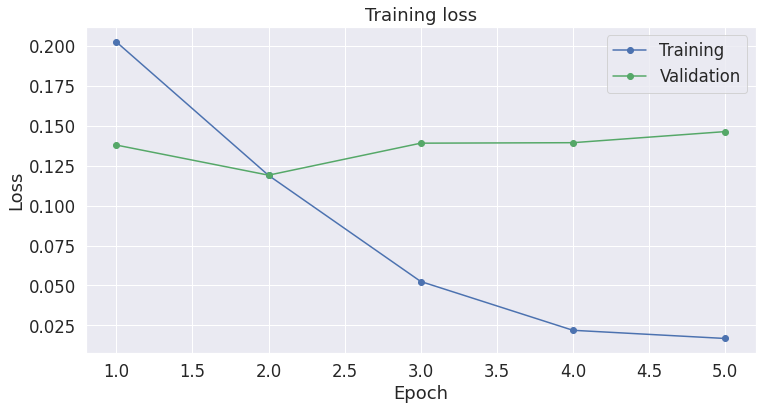

In [ ]:
# plot the train statistics stored in training_stats
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "darkgrid")

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = [12, 6]

df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# make sure to save the model performance statistics and the associated model configuration. 
# that is save the df_stats to csv file with a file name, say experiment 1
df_stats.to_csv(os.path.join(dir, 'label_experiment_health_stats.csv'))
# save the key hyper-parameters of this training experiment, say experiment 1
label_experiment_health = {
    "epochs": epochs,
    "train_batch_size" : train_batch,
    "valid_batch_size" : valid_batch,
    "initial_learning_rate": learning_rate,
     "max_sentence_length": max_length,
     "loss_fucntion": criterion,
     "optimizer": optimizer,
     # you need to manually type-in the following info
     "BERT output": "mean value of [cls] embeddings of non-padded token from the second to the last layer",
     "activation function": "relu",
     "dropout rate of BERT output": model_amazon.l2,
     "# of fully connected linear layer": 1,
     "dataset": "Amazon Old Reviews Dataset",
     "comment": "The model seems to be working accordingly."
}


In [ ]:
# save the experiment configurate assocaited with this experiment
# note that if you click the file icon (the third vertical one on the far left)
# you will see the save files, double click on them, you can see them.
import csv
with open(os.path.join(dir, 'label_experiment_health_config.csv'), 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in label_experiment_health.items():
       writer.writerow([key, value])

## Evaluate the Model Performance

In [ ]:
# apply the trained model to the validation dataset
# get the model predictions and compare the comparisons to the true labels
model_amazon.eval()
predictions, labels = [], []
for step, batch in enumerate(valid_loader):
  input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  label = batch['label'].to('cpu').numpy()
  
  with torch.no_grad():
    prediction = model_amazon(input_ids, attention_mask)

  prediction = prediction.detach().cpu().numpy()
  predictions.append(prediction)
  labels.append(label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# call the helper function-- pred_accuacy to compute the prediction accuracy in each batch
ac = []
for i in range(len(predictions)):
  ac_i = pred_accuracy(predictions[i], labels[i])
  ac.append(ac_i)
ac

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
# transfer the outcomes into np
predictions = np.asarray(predictions)
labels = np.asarray(labels)
predictions[0]
# note that now the outcomes are still stored in batches

array([[0.00561837],
       [0.00536927],
       [0.00552698],
       [0.00548297],
       [0.00534314],
       [0.00598945],
       [0.0053527 ],
       [0.00595799],
       [0.0058663 ],
       [0.00554708],
       [0.00544025],
       [0.00543119],
       [0.98453474],
       [0.00543794],
       [0.00543362],
       [0.00550991],
       [0.00541646],
       [0.00545827],
       [0.00561792],
       [0.00551827],
       [0.00543936],
       [0.00547449],
       [0.00553366],
       [0.00559984],
       [0.00538461],
       [0.0055438 ],
       [0.00560541],
       [0.00543569],
       [0.00549313],
       [0.00569603],
       [0.00568539],
       [0.00561495]], dtype=float32)

In [ ]:
# convert predictions stored in the batches into a long vector
pred = np.concatenate(predictions, axis=0 )
pred = np.concatenate(pred, axis=0 )
pred = pred.reshape(len(pred),1)
print(pred.shape)

(166, 1)


In [ ]:
# convert the true labels batches into a long vector
true_label = np.concatenate(labels, axis=0 )
true_label = true_label.reshape(len(true_label), 1)
print(true_label.shape)
type(true_label)

(166, 1)


numpy.ndarray

In [ ]:
# put the predictions and labels into the same dataset
df = np.concatenate([pred, true_label], axis = 1)
df = pd.DataFrame(data=df, columns=["preds", "labels"])
df

,preds,labels
0,0.005618,0.0
1,0.005369,0.0
2,0.005527,0.0
3,0.005483,0.0
4,0.005343,0.0
...,...,...
161,0.983066,1.0
162,0.005974,0.0
163,0.005419,0.0
164,0.005438,0.0


In [ ]:
# see the total prediction accuracy
sum((df["preds"]>=0.5) == df["labels"])

166

In [ ]:
# find the index of the review that has the lowest predicted probabilty(of being a positive review) in true_label == 1 group. 
df.loc[df.loc[df['labels'] == 1, :].idxmin()]

,preds,labels
49,0.982054,1.0
12,0.984535,1.0


In [ ]:
# see that review
valid_raw.iloc[1,0]


"Just got it today can't believe the great sound. Took it out of the box in my car paired it unbelievable .<br />Haven't had it long enough to rate the battery's"

In [ ]:
# alternatively, for all the reviews that have true_label == 1, 
# let's sort their predicted probabilities
df.loc[df['labels'] == 1, :].sort_values('preds')

,preds,labels
49,0.982054,1.0
62,0.982081,1.0
161,0.983066,1.0
80,0.983174,1.0
125,0.983486,1.0
96,0.983582,1.0
12,0.984535,1.0


In [ ]:
df[df['labels']==1].preds.sort_values()[0:20]

49     0.982054
62     0.982081
161    0.983066
80     0.983174
125    0.983486
96     0.983582
12     0.984535
Name: preds, dtype: float32

In [ ]:
valid_raw.iloc[49,0]

"I tried many diets pills before from almost every company. All the pills seem to give me the headache and heart racing affect. Best slim gave me best result, within first week I lost 5 pounds and within this first month I lost over 15 pounds. Even though this might not be the real deal, but since been taking this I lost the weight I don't need. I just got 10 more pounds to lose. Best slim is the way to lose weight with no weird feeling affect."

In [ ]:
# see the reviews
valid_raw.iloc[158,0]

'Bought this for my twins for meds for thrush. They were 3 months. It is a great idea however it is hard to hold because of the size'

In [ ]:
valid_raw.iloc[137,0]

"Other than the sizing that is bigger than the usual (as is Carhartt tradition), the jacket is just what I wanted. It is medium/heavy warmth, coated with durable sandstone duck, and well constructed. I'm looking forward to wearing this in more, and the sherpa isn't itchy (in case you were wondering). I'll update this review over time with anything major that changes, but for now this is another great Carhartt!"

In [ ]:
# on the other way around, for all the reviews whose label == 0, 
# let's sort their predicted probablities in descending order
df[df['labels'] == 0].sort_values('preds', ascending = False)

,preds,labels
73,0.013619,0.0
110,0.011661,0.0
155,0.010588,0.0
137,0.009841,0.0
98,0.007770,0.0
...,...,...
34,0.005350,0.0
77,0.005349,0.0
4,0.005343,0.0
56,0.005340,0.0


In [ ]:
# see the reviews
# after learning some examples, it seems that our model will give a high score as long as the food is good
# even though the service is not. 
valid_raw.iloc[43,0]

'These are 20 miu of hcg sensitivity. First Response claims to be 15 miu. So these are pretty good. Also no evap lines. I confirmed with a first response after my positive result and these were correct.'

In [ ]:
valid_raw.iloc[30,0]

"I was excited to get these drops, but when they came in I saw that nowhere in the box or bottle does it say HCG. So I don't know if they are real or fake. I read online that if you pay less than $80 for a bottle claiming that it's HCG then their probably fake and what your taking is a water and alcohol which would suck because these drops do taste like alcohol. I don't know if their real or not im just rating them a 3 because my drops came in and I'm hoping that their real."

In [ ]:
valid_raw.iloc[45,0]

"i like how this is natural and vegan. I got this when i was pregnant and i'm still taking it now."

# **Second Test - Augmentation(performance decreased)**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
url='data_old_amazon_reviews.csv'

In [ ]:
raw_review=pd.read_csv(url)
raw_review

,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,social connectedness,environment,self_sufficiency,transparency_authenticity,tradition,individuality,diversity_equality,privacy,status,thrift_value,innovation,fun_adventure,health
0,BOSS HUGO BOSS Men's Starfish Swim Trunk,Apparel,4,0,0,N,N,Good quality,"The quality is good, fits good but I didnt pay...",6/23/2014,0,0,0,0,0,1,0,0,0,1,0,0,0
1,Vedette Megane Firm Compression Sensual Corset...,Apparel,4,1,2,N,Y,I like this bodyshaper.,This body shaper does what it says. It makes y...,9/1/2013,0,0,0,0,0,1,0,0,0,1,0,0,1
2,Adult Stilinski 24 Beacon Hills Lacrosse 2-Sid...,Apparel,5,0,0,N,Y,Nice hoodie,It looks well made. I bought it for my grandda...,8/3/2015,1,0,0,0,0,0,0,0,0,1,0,0,0
3,Carhartt Men's Sherpa Lined Sandstone Hooded M...,Apparel,5,3,3,N,Y,Size Small Means Medium,Other than the sizing that is bigger than the ...,10/2/2014,0,0,0,0,0,0,0,0,1,1,0,0,1
4,Roxy Juniors Gallery Backpack,Apparel,5,0,0,N,Y,Five Stars,Love my backpack.,9/15/2014,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,Virus Removal Service - Jupiter Support,Software,5,0,0,N,N,IE issue,i just got done with jupiter on i script prob ...,4/26/2014,0,0,0,0,0,0,0,0,0,1,0,0,0
1657,Family Tree Maker 2011 Deluxe [Old Version],Software,3,1,2,Y,N,Not for use on a netbook,I used this software on my netbook and it divi...,9/23/2011,0,0,0,0,0,0,0,0,0,1,0,0,0
1658,"Learn Italian: Fluenz Italian 1 for Mac, PC, i...",Software,5,2,2,N,N,awesome program,"hi, Just want to say it what a great company! ...",4/30/2010,0,0,0,0,0,0,0,0,0,1,0,0,0
1659,Kaspersky Internet Security 2009 (3 User),Software,5,0,0,N,Y,Great product,Great internet security product. I guess the b...,12/22/2008,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
train_review = pd.DataFrame(None)

train_review[['text','label']] = raw_review[['review_body','health']].iloc[0:1661,:]

In [ ]:
train_review=train_review.dropna()

In [ ]:
train_review.describe()

,label
count,1660.000000
mean,0.068675
std,0.252976
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Define a Customized Dataset Class and Setup the Dataloader

In [ ]:
max_length = 128
train_batch = 32
valid_batch = 32

In [ ]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
class AmazonDataset(Dataset):

  def __init__(self, dataset, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataset
    self.text = dataset.text
    self.label = dataset.label
    self.max_len = max_len
  

  def __len__(self):
    return len(self.text)


  def __getitem__(self, index):
    text = self.text.iloc[index]

    outputs = self.tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        padding = "max_length",
        truncation = "longest_first",
        add_special_tokens = True,
        return_tensors = 'pt'
    )

    input_ids = outputs['input_ids']
    attention_mask = outputs['attention_mask']
    
    return {
        'input_ids': torch.tensor(input_ids, dtype = torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
        'label': torch.tensor(self.label.iloc[index], dtype = torch.float) 
    }

In [ ]:
from sklearn.model_selection import train_test_split
train_raw, valid_raw = train_test_split(train_review, test_size = 0.1)

In [ ]:
train_raw

,text,label
222,"Beautiful nightgown, love the colored flower d...",0
1188,"Easy Install, looks great!",0
1286,"When I received my order, another type of oil ...",0
438,"So far, so good. The battery fit fine and conn...",0
507,I am not an expert by any means. I just listen...,0
...,...,...
164,Fine,0
608,Terrible...Chinese knock off....does not work ...,0
1569,I bought this from Amazon for about $19 incl s...,0
415,The product was ordered and 3 day later I had ...,0


In [ ]:
health = pd.read_csv('health_augmented.csv')
health

,text,label
0,these multis have been working for me for coup...,1
1,these have working for me for a couple of now ...,1
2,these multis dose have been working for me for...,1
3,need multis have been working for me for a cou...,1
4,these multis have been working for me for a tw...,1
...,...,...
1012,i really adenine wanted to maine like this bra...,1
1013,i really wanted to like this constitute bra th...,1
1014,i really wanted to wrinkled this while irritat...,1
1015,i truly wanted to similar this bra the stain j...,1


In [ ]:
frames=[train_raw,health]
train_raw = pd.concat(frames)

In [ ]:
train_raw.shape

(2511, 2)

In [ ]:
train_processed = AmazonDataset(train_raw, tokenizer, max_length)
valid_processed = AmazonDataset(valid_raw, tokenizer, max_length)

In [ ]:
train_sampler = RandomSampler(train_processed)
train_loader = DataLoader(train_processed, batch_size = train_batch, num_workers = 0)
valid_sampler = SequentialSampler(valid_processed)
valid_loader = DataLoader(valid_processed, batch_size = valid_batch, num_workers = 0)

In [ ]:
print(len(train_loader))
print(len(valid_loader))

79
6


## Define a Customized Neural Network with the First Hidden Layer as NLP Encoding Layer

In [ ]:
import torch.nn.functional as F

In [ ]:
class AmazonBERT(torch.nn.Module):

  def __init__(self):
    super(AmazonBERT, self).__init__()

    self.l1 = model

    self.l2 = torch.nn.Dropout(0.3) 

    self.l3 = torch.nn.Linear(768, 1)


  def forward(self, input_ids, attention_mask):

    last, pooler = self.l1(input_ids = input_ids, attention_mask = attention_mask)
   
    output = last[:, 0 : attention_mask.sum(), :].mean(dim = 1)
    output = F.relu(output.squeeze())
    output = F.relu(self.l2(output))
    output = self.l3(output)

    return torch.sigmoid(output)

In [ ]:
l1 = model
l1.to(device)
input_ids = train_processed.__getitem__(10)['input_ids'].to(device)
attention_mask = train_processed.__getitem__(10)['attention_mask'].to(device)
last, pooler = l1(input_ids = input_ids, attention_mask = attention_mask)
print(last.shape)
print(last.squeeze().shape)
print(pooler.shape)
print(pooler.squeeze().shape)

torch.Size([1, 128, 768])
torch.Size([128, 768])
torch.Size([1, 768])
torch.Size([768])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
output = last[:, 1 : attention_mask.sum(), :].mean(dim = 1)
output = output.squeeze()
output.shape
l2 = torch.nn.Dropout(0.3)   
l2.to(device)
l3 = torch.nn.Linear(768, 1)
l3.to(device)
output.to(device)
l3(l2(torch.tensor(output)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


tensor([-0.9102], device='cuda:0', grad_fn=<AddBackward0>)

## Create a BERT + NN Model as an Instance of the Customized Model Classs Defined Above and Setup the Loss Function and Optimizer

In [ ]:
model_amazon = AmazonBERT()
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
criterion = nn.BCELoss()

In [ ]:
learning_rate = 10e-05

In [ ]:
epochs = 10

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model_amazon.parameters(),lr = learning_rate,eps = 1e-8)
                  
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
import numpy as np
def pred_accuracy (prediction, label):
  pred_flat = np.around(prediction).flatten()
  label_flat = label.flatten()
  return np.sum(pred_flat == label_flat) / len(label_flat)

## Train the BERT + NN Model and Evaluate the Performance

In [ ]:
import random
seed_val = 45
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model_amazon = AmazonBERT()
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
# set up the directory for storing the trained model
import os
# save to Google Drive
dir = "/content/drive/My Drive"
# save to local file
# dir = "E://OneDrive - lmu.edu//Python Projects//BERT and ML"


In [ ]:
# Very Important: Each Time When You Train a Neural Network Again, 
# Plase recreate the nural network, the dataloader, and the optimizer and its scheduler.


# train the model 
# store the total loss and accuracy values of each epoch
training_stats = []

# the epoch loop, number of rounds specified by epochs
for epoch_i in range(0, epochs):
  print('======== Epoch {:} / {:} =========='.format(epoch_i + 1, epochs))
  # zero the values of total loss and accuracy of the epoch
  total_loss = 0
  total_accuracy = 0
  # in the training stage, set the model into train mode
  model_amazon.train()

  # the training step loop
  # recall that train_loader feed data into the NN in batchs to save memory and improve efficiency
  # then the # of total steps is about (# of samples/batch size)
  print("training")
  for step, batch in enumerate(train_loader, 0):
    # feed the data into GPU using .to(device) method
    # note that the input_ids for one raw input is in the shape of (1, max_length)
    # after be processed into batch, the input_ids become (batch_size, 1, max_length)
    # however, BERT only takes input_ids in the shape of (batch_size, max_length),
    # (see here: https://huggingface.co/transformers/model_doc/bert.html#bertmodel)
    # so we need to do "batch['input_ids'].squeeze()" inestead of "batch['input_ids']"
    # to remove the unnecessy axis of "1". 
    # same operation for attention_mask
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    # at each step, before the NN does the feed forward, let's set the gradient to 0
    # as pytorch nn.Module automatically cumulates gradient from previous rounds
    # this is good for RNN training, but not necessy for us here. Thus, we turn it off.   
    optimizer.zero_grad()
    
    # for each raw input, the feed forward calculation give us two scalar, 
    # representing the score/probability of the sample being 0/bad review class or 1/good review class  
    # note that since we feed the inputs/raw samples in batch, 
    # the prediciton should be in the shape of (batch_size, # of classes)
    prediction = model_amazon(input_ids, attention_mask)
    prediction = prediction.squeeze()

    # criterion is defined as a cross entropy loss function
    # it takes (prediction, ground truth) as input arugments
    # the former should be in the shape of (batch_size, # of classes), 
    # the latter should be in the sahpe of (batch_szie, 1), "1" dimension records the true class id of the input
    # https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html   
    loss = criterion(prediction, label)

    # with the loss, we can do back propagation to calculate the gradient
    # very easy, just one line of code  
    loss.backward()

    # with the gradient, we can update the model paramters. 
    # recall how we define the optimizer in the above cell  
    optimizer.step()
    
    # update the learning rate
    scheduler.step()

    # to keep tracking on the model performance, we accumulate the total loss in every epoch  
    total_loss += loss.item()
      
    # for every 10 steps, we print out the epoce # and loss
    # again, the max_length of raw text input is 256, relatively long than usual, thus it will take longer to train. 
    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')
  
  # calcualte and store the average training loss of each batch in the current epoch
  avg_train_loss = total_loss / len(train_loader)

  

  # now let's set up the validation loop, meaning the trained model above will be used to evaluate the sample in validation dataset
  # note that this validation loop is in the same "indent" level as the training loop, and they both under the epoches loop
  print("validating")
  # set the model now in the evaluation mode
  model_amazon.eval()
  # zero the values of total loss and accuracy
  total_loss = 0
  #total_accuracy = 0

  # validation loop
  for step, batch in enumerate(valid_loader, 0):
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    with torch.no_grad():
        prediction = model_amazon(input_ids, attention_mask)
        prediction = prediction.squeeze()
        loss = criterion(prediction, label)

    total_loss += loss.item()

    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')

  # calcualte and store the average training loss of each batch in the current epoch
  avg_valid_loss = total_loss / len(valid_loader)

  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_valid_loss
        }
    )
  


  # lastly, at the end of each epoch, let's save the model for later use
  # note that dir is defined before as "./content/drive/My Drive"  
  torch.save(model_amazon.state_dict(), os.path.join(dir, 'exper-epoch-{}.pt'.format(epoch_i)))

print("training complete!")



======== Epoch 1 / 10 ==========
training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:1, Total_Loss:1.8312144801020622, Average_Loss:0.18312144801020622
Epoch:1, Total_Loss:4.3267835304141045, Average_Loss:0.21633917652070522
Epoch:1, Total_Loss:7.417190380394459, Average_Loss:0.24723967934648197
Epoch:1, Total_Loss:9.180097313597798, Average_Loss:0.22950243283994495
Epoch:1, Total_Loss:12.475992860272527, Average_Loss:0.24951985720545053
Epoch:1, Total_Loss:12.781140619888902, Average_Loss:0.21301901033148168
Epoch:1, Total_Loss:12.923435324802995, Average_Loss:0.1846205046400428
validating
======== Epoch 2 / 10 ==========
training
Epoch:2, Total_Loss:21.337087228894234, Average_Loss:2.1337087228894234
Epoch:2, Total_Loss:23.799394447356462, Average_Loss:1.1899697223678232
Epoch:2, Total_Loss:27.29811381176114, Average_Loss:0.9099371270587047
Epoch:2, Total_Loss:29.742653850466013, Average_Loss:0.7435663462616503
Epoch:2, Total_Loss:42.41599662974477, Average_Loss:0.8483199325948954
Epoch:2, Total_Loss:52.915363881736994, Average_Loss:0.8819227313622833
Epoch:2, 

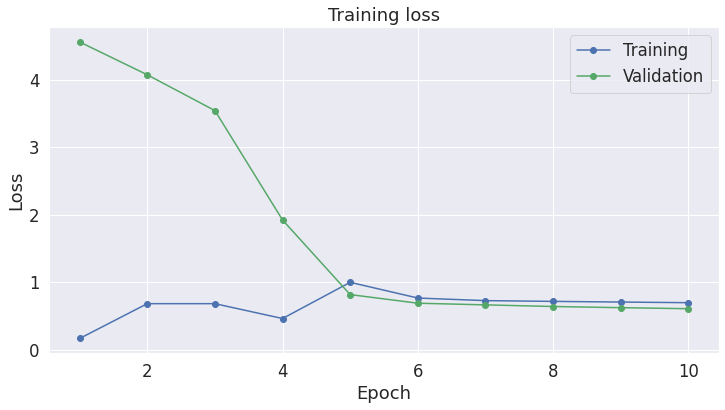

In [ ]:
# plot the train statistics stored in training_stats
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "darkgrid")

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = [12, 6]

df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# make sure to save the model performance statistics and the associated model configuration. 
# that is save the df_stats to csv file with a file name, say experiment 1
df_stats.to_csv(os.path.join(dir, 'label_experiment_health_augmented_stats.csv'))
# save the key hyper-parameters of this training experiment, say experiment 1
label_experiment_health_augmented = {
    "epochs": epochs,
    "train_batch_size" : train_batch,
    "valid_batch_size" : valid_batch,
    "initial_learning_rate": learning_rate,
     "max_sentence_length": max_length,
     "loss_fucntion": criterion,
     "optimizer": optimizer,
     # you need to manually type-in the following info
     "BERT output": "mean value of [cls] embeddings of non-padded token from the second to the last layer",
     "activation function": "relu",
     "dropout rate of BERT output": model_amazon.l2,
     "# of fully connected linear layer": 1,
     "dataset": "Old Amazon Reviews + Augmentation",
     "comment": "Overfitting until epoch 7, when it seems to be more stable."
}


In [ ]:
# save the experiment configurate assocaited with this experiment
# note that if you click the file icon (the third vertical one on the far left)
# you will see the save files, double click on them, you can see them.
import csv
with open(os.path.join(dir, 'label_experiment_health_augmented_config.csv'), 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in label_experiment_health_augmented.items():
       writer.writerow([key, value])

## Evaluate the Model Performance

In [ ]:
# apply the trained model to the validation dataset
# get the model predictions and compare the comparisons to the true labels
model_amazon.eval()
predictions, labels = [], []
for step, batch in enumerate(valid_loader):
  input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  label = batch['label'].to('cpu').numpy()
  
  with torch.no_grad():
    prediction = model_amazon(input_ids, attention_mask)

  prediction = prediction.detach().cpu().numpy()
  predictions.append(prediction)
  labels.append(label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# call the helper function-- pred_accuacy to compute the prediction accuracy in each batch
ac = []
for i in range(len(predictions)):
  ac_i = pred_accuracy(predictions[i], labels[i])
  ac.append(ac_i)
ac

[0.9375, 0.9375, 0.96875, 0.9375, 0.9375, 1.0]

In [ ]:
# transfer the outcomes into np
predictions = np.asarray(predictions)
labels = np.asarray(labels)
predictions[0]
# note that now the outcomes are still stored in batches

array([[0.44925356],
       [0.44925362],
       [0.44925356],
       [0.44925362],
       [0.44925362],
       [0.44925362],
       [0.44925356],
       [0.44925362],
       [0.44925356],
       [0.44925356],
       [0.44925362],
       [0.44925356],
       [0.44925362],
       [0.44925362],
       [0.44925362],
       [0.44925356],
       [0.44925362],
       [0.44925362],
       [0.44925356],
       [0.44925362],
       [0.44925362],
       [0.44925362],
       [0.44925362],
       [0.44925362],
       [0.44925362],
       [0.44925362],
       [0.44925362],
       [0.44925356],
       [0.44925356],
       [0.44925356],
       [0.44925356],
       [0.44925356]], dtype=float32)

In [ ]:
# convert predictions stored in the batches into a long vector
pred = np.concatenate(predictions, axis=0 )
pred = np.concatenate(pred, axis=0 )
pred = pred.reshape(len(pred),1)
print(pred.shape)

(166, 1)


In [ ]:
# convert the true labels batches into a long vector
true_label = np.concatenate(labels, axis=0 )
true_label = true_label.reshape(len(true_label), 1)
print(true_label.shape)
type(true_label)

(166, 1)


numpy.ndarray

In [ ]:
# put the predictions and labels into the same dataset
df = np.concatenate([pred, true_label], axis = 1)
df = pd.DataFrame(data=df, columns=["preds", "labels"])
df

,preds,labels
0,0.449254,1.0
1,0.449254,0.0
2,0.449254,0.0
3,0.449254,0.0
4,0.449254,0.0
...,...,...
161,0.449254,0.0
162,0.449254,0.0
163,0.449254,0.0
164,0.449254,0.0


In [ ]:
# see the total prediction accuracy
sum((df["preds"]>=0.5) == df["labels"])

157

In [ ]:
# find the index of the review that has the lowest predicted probabilty(of being a positive review) in true_label == 1 group. 
df.loc[df.loc[df['labels'] == 1, :].idxmin()]

,preds,labels
0,0.449254,1.0
0,0.449254,1.0


In [ ]:
# see that review
valid_raw.iloc[86,0]


'The Official Nintendo Wii Power Supply Adapter was everything it was advertised to be. It works great!'

In [ ]:
# alternatively, for all the reviews that have true_label == 1, 
# let's sort their predicted probabilities
df.loc[df['labels'] == 1, :].sort_values('preds')

,preds,labels
0,0.449254,1.0
60,0.449254,1.0
124,0.449254,1.0
12,0.449254,1.0
49,0.449254,1.0
84,0.449254,1.0
96,0.449254,1.0
142,0.449254,1.0
152,0.449254,1.0


In [ ]:
df[df['labels']==1].preds.sort_values()[0:20]

0      0.449254
60     0.449254
124    0.449254
12     0.449254
49     0.449254
84     0.449254
96     0.449254
142    0.449254
152    0.449254
Name: preds, dtype: float32

In [ ]:
# see the reviews
valid_raw.iloc[133,0]

'it fits'

In [ ]:
# on the other way around, for all the reviews whose label == 0, 
# let's sort their predicted probablities in descending order
df[df['labels'] == 0].sort_values('preds', ascending = False)

,preds,labels
1,0.449254,0.0
63,0.449254,0.0
109,0.449254,0.0
106,0.449254,0.0
104,0.449254,0.0
...,...,...
101,0.449254,0.0
99,0.449254,0.0
98,0.449254,0.0
37,0.449254,0.0


In [ ]:
# see the reviews
# after learning some examples, it seems that our model will give a high score as long as the food is good
# even though the service is not. 
valid_raw.iloc[51,0]

"I'm giving this five stars purely on function, it is not the best tactile experience and lacts some programming features but fills a nitch that i could not find anywhere else. If you are no longer using a cable STB and watch a majority of video content on the web (I'm using it with a Mac mini htpc) and don't want a 40 button monster remote then this is a perfect fit, Of the three functions, one is your tv which becomes the standard channel up/down volume up/down input select and mute. The next two become your audio receiver or a/v receiver and the last becomes your media device (apple tv or htpc for example). Programming is pretty standard but I could not reprogram the menu button since it is used to exit the programming mode. Other than that the only other problem I have with it is the small throw of the buttons. I could not find the programming code map on the web so if you are wondering it includes a very large tv, av receiver and audio receiver list along with a list of media devi

# **Save and Load a Trained Model**

In [13]:
# check the tutorial here:
# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch

# if you want to save the trained model for later evaluation (not for training)
#dir = "/content/drive/My Drive/" 
#torch.save(model_amazon.state_dict(), os.path.join(dir, 'amazon_health.pt'))

# later if you want to load the model and use it for evaluation (not trianing), do this: 
# the_model = TheModelClass(*args, **kwargs), in our case
model_amazon = AmazonBERT()

# and the_model.load_state_dict(torch.load(PATH)), note that path is specified above
model_amazon.load_state_dict(torch.load('/content/drive/My Drive/amazon_health.pt'))

<All keys matched successfully>

# **Prediction of New Amazon Reviews**

In [19]:
import pandas as pd
import numpy as np

In [20]:
current_reviews = pd.read_csv('all_reviews_v3.0.csv')

In [21]:
current_reviews.shape

(135800, 14)

In [22]:
current_reviews['health'] = np.nan

In [23]:
current = pd.DataFrame(None)

current[['text','label']] = current_reviews[['text','health']]

In [24]:
current.head()

,text,label
0,This Columbia jacket is a pretty good quality ...,NaN
1,Just as expected! Perfect rain jacket for todd...,NaN
2,I bought this for a Birthday gift and haven't ...,NaN
3,This is perfect for those fall and spring days...,NaN
4,good color,NaN


In [25]:
current.shape

(135800, 2)

In [26]:
current['text'].isnull().sum()

0

In [27]:
processed=AmazonDataset(current,tokenizer,max_length)

In [28]:
pred_sampler=SequentialSampler(processed)
pred_loader=DataLoader(processed,batch_size=valid_batch,num_workers=0)

In [29]:
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [30]:
model_amazon.eval()
predictions_2 = []
for step, batch in enumerate(pred_loader):
  input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  
  with torch.no_grad():
    prediction_2 = model_amazon(input_ids, attention_mask)

  prediction_2 = prediction_2.detach().cpu().numpy()
  predictions_2.append(prediction_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [33]:
predictions_2=np.asarray(predictions_2)
predictions_2[0]

array([[0.00586069],
       [0.00627835],
       [0.00581595],
       [0.0063597 ],
       [0.00553786],
       [0.01319154],
       [0.00575154],
       [0.0091722 ],
       [0.00681635],
       [0.00585504],
       [0.00555751],
       [0.00547979],
       [0.0058609 ],
       [0.00574112],
       [0.00561169],
       [0.00576321],
       [0.00547936],
       [0.00613483],
       [0.00624798],
       [0.00650673],
       [0.00550462],
       [0.00642864],
       [0.00598508],
       [0.00646051],
       [0.00563063],
       [0.00628307],
       [0.00609014],
       [0.00544106],
       [0.00555814],
       [0.00630912],
       [0.00539136],
       [0.00617186]], dtype=float32)

In [35]:
pred_3=np.concatenate(predictions_2,axis=0)
pred_3=np.concatenate(pred_3,axis=0)
pred_3=pred_3.reshape(len(pred_3),1)
print(pred_3.shape)

(135800, 1)


In [36]:
df_3=pd.DataFrame(data=pred_3,columns=['preds'])
df_3

,preds
0,0.005861
1,0.006278
2,0.005816
3,0.006360
4,0.005538
...,...
135795,0.005483
135796,0.005483
135797,0.005447
135798,0.005450


In [38]:
current_reviews['health_pred'] = df_3

In [39]:
current_reviews.drop(columns=['health'], inplace=True)

In [41]:
current_reviews.iloc[:,-1]

0         0.005861
1         0.006278
2         0.005816
3         0.006360
4         0.005538
            ...   
135795    0.005483
135796    0.005483
135797    0.005447
135798    0.005450
135799    0.005594
Name: health_pred, Length: 135800, dtype: float32

In [44]:
current_reviews

,index,asin,productTitle,countReviews,date,imageUrlList,numberOfHelpful,parentReviewId,rating,reviewId,text,title,username,category,health_pred
0,1,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/16/2020,NaN,0,NaN,3,R385E1LP3AE40R,This Columbia jacket is a pretty good quality ...,Pretty good rain jacket,June B Furr,apparel,0.005861
1,2,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/15/2020,NaN,0,NaN,5,R36I6DUHDK4HIB,Just as expected! Perfect rain jacket for todd...,Toddler approved,Meeko0924,apparel,0.006278
2,3,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/14/2020,NaN,0,NaN,4,R4YTDBV1VENF6,I bought this for a Birthday gift and haven't ...,Birthday gift,Vera T.,apparel,0.005816
3,4,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/11/2020,NaN,0,NaN,5,RMQ5B577OTPJY,This is perfect for those fall and spring days...,Good jacket,RD,apparel,0.006360
4,5,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/10/2020,NaN,0,NaN,5,R12IYTDMAX94FD,good color,very good,ivy,apparel,0.005538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135795,135796,B07FV9GW8S,Corel Paintshop Pro 2019 Ultimate - Photo with...,128,11/6/2018,NaN,5,NaN,3,R1IP5E8DS9YEP3,UPDATE 11/23/2018: I'm dropping the rating a s...,"Excellent Value, Potential Alternative to Phot...",Amazon Customer,software,0.005483
135796,135797,B07FV9GW8S,Corel Paintshop Pro 2019 Ultimate - Photo with...,128,11/5/2018,NaN,12,NaN,4,R2AVKQCZXW4IGN,"PaintShop Pro 2019 comes in a box with a DVD, ...",A Quirky but Reasonable Application for Image ...,Jeffrey N. Fritz,software,0.005483
135797,135798,B07FV9GW8S,Corel Paintshop Pro 2019 Ultimate - Photo with...,128,10/31/2018,NaN,3,NaN,4,R1YTIJIGJ4IMT7,I see by the reviews that a LOT of folks had p...,Some times you eat the bear and sometimes...,enubrius,software,0.005447
135798,135799,B07FV9GW8S,Corel Paintshop Pro 2019 Ultimate - Photo with...,128,10/30/2018,NaN,4,NaN,3,R3FO4N6RUDI1EY,I had the disc and still experienced installat...,Paintshop Pro 2019 Ultimate - Photo with Multi...,new yorker,software,0.005450


In [42]:
current_reviews.to_csv(r'predicted_health_reviews.csv', index = False)

In [ ]:
df_3.sort_values(by='preds',ascending=False)

,preds
21447,0.984972
22830,0.984953
21666,0.984952
21897,0.984939
22304,0.984931
...,...
19865,0.005310
3942,0.005308
20639,0.005304
10287,0.005296


In [ ]:
current.iloc[4553,0]

'Ordered Xl, too big. I wear other Cherokee xl and they fit fine, this cut is generous. No drawstring to hold up- so they fall down'

In [ ]:
current.iloc[2798,0]

'This unit keeps failing. Either shuts off all together or the alert keeps going and have to unplug to stop. Seems a pain to return but Iâ€™m considering doing so.'

In [ ]:
current.iloc[4723,0]

"I've tried so many hand soap and I have to say this would remain one of my favorites. It helps my hands stay clean while not hurting my sensitive skin. I have to say the fresh scent is okay. I personally like it very much but my friend would not. Also, it does not have a moisturizing feature. But this is a value purchase."

In [ ]:
current.iloc[2803,0]

'Amazing microwave, quiet and has all the easy-button features we like...'

In [ ]:
current.iloc[2287,0]

'Packaged well, shipping was fast. Great microwave!'

In [ ]:
current.iloc[4639,0]

'Works well I put it in another container... looks good now too'

In [ ]:
current.iloc[513,0]

'Great quality jacket, fits perfectly. I definitely recommend.'

In [ ]:
df_3.iloc[2500]

preds    0.005441
Name: 2500, dtype: float32

In [ ]:
current.iloc[2500,0]

"I got one, which was not in working condition, the smart keypad wasn't functioning so I sent it back and got the replacement next day. But somehow not happy with the replacement also as sometime touchpad is not functioning and I need to push couple of times"

In [ ]:
for ind in df_3.index:
  if df_3['preds'][ind] >= 0.5:
    current.label[ind]=1
  else:
    current.label[ind]=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
